# Sentiment Analysis for Drug Reviews

By: Riya Shrestha, Lynda Solis Chavez, and Felicia Liu

In [1]:
!pip install wordcloud==1.8.2.2
!pip install transformers==4.27.4
!pip install graphviz
!pip install pydotplus
!pip install sklearn.externals.six

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
ERROR: Could not find a version that satisfies the requirement sklearn.externals.six (from versions: none)
ERROR: No matching distribution found for sklearn.externals.six
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns 
sns.set(style="darkgrid")  
import plotly.graph_objs as plotly 
import re
import tensorflow as tf
from textblob import TextBlob
from wordcloud import WordCloud
import nltk
from nltk.corpus import *
from nltk.tokenize import (word_tokenize, sent_tokenize, TreebankWordTokenizer, wordpunct_tokenize, TweetTokenizer, MWETokenizer)
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

2023-04-18 16:50:11.492705: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 16:50:11.594313: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-18 16:50:11.598981: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-18 16:50:11.598998: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

# Exploratory Data Analysis (Train Data)

Loading the data

In [3]:
df = pd.read_csv("drugsComTrain_raw.csv")
df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [4]:
df_test = pd.read_csv("drugsComTest_raw.csv")
df_test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [5]:
df.shape

(161297, 7)

In [6]:
df_test.shape

(53766, 7)

In [7]:
df['review']

0         "It has no side effect, I take it in combinati...
1         "My son is halfway through his fourth week of ...
2         "I used to take another oral contraceptive, wh...
3         "This is my first time using any form of birth...
4         "Suboxone has completely turned my life around...
                                ...                        
161292    "I wrote my first report in Mid-October of 201...
161293    "I was given this in IV before surgey. I immed...
161294    "Limited improvement after 4 months, developed...
161295    "I&#039;ve been on thyroid medication 49 years...
161296    "I&#039;ve had chronic constipation all my adu...
Name: review, Length: 161297, dtype: object

Checking to see if the data has any missing values

In [8]:
df.isna().any()

uniqueID       False
drugName       False
condition       True
review         False
rating         False
date           False
usefulCount    False
dtype: bool

In [9]:
df['condition'].isna().sum()

899

Checking column datatypes

In [10]:
df.dtypes

uniqueID        int64
drugName       object
condition      object
review         object
rating          int64
date           object
usefulCount     int64
dtype: object

Looking into how many drugName entries each condition has

In [11]:
drugs_cond = df.groupby(['condition'])['drugName']
drugs_cond_cnt = drugs_cond.count().sort_values(ascending = False)
drugs_cond_cnt

condition
Birth Control                              28788
Depression                                  9069
Pain                                        6145
Anxiety                                     5904
Acne                                        5588
                                           ...  
Radionuclide Myocardial Perfusion Study        1
Rabies Prophylaxis                             1
Q Feve                                         1
Bartonellosis                                  1
Anti NMDA Receptor Encephalitis                1
Name: drugName, Length: 884, dtype: int64

Looking at number of drugs per condition

In [12]:
drugs_cond = df.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
drugs_cond

condition
Not Listed / Othe                              214
Pain                                           200
Birth Control                                  172
High Blood Pressure                            140
Acne                                           117
                                              ... 
Sepsis                                           1
72</span> users found this comment helpful.      1
Microscopic polyangiitis                         1
Short Stature                                    1
Epicondylitis, Tennis Elbow                      1
Name: drugName, Length: 884, dtype: int64

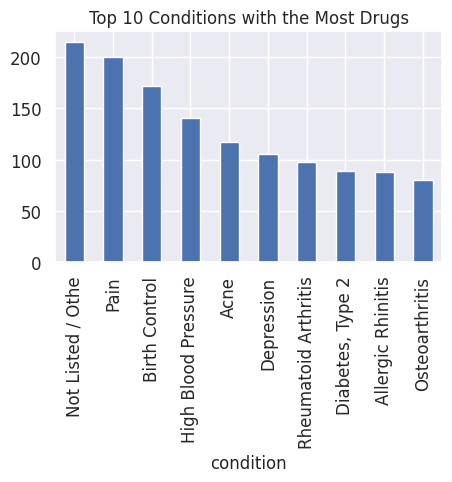

In [13]:
drugs_cond[0:10].plot(kind="bar", figsize = (5,3), fontsize = 12) # looking at the top 10 Conditions with the most drugs
plt.title("Top 10 Conditions with the Most Drugs");

Making histogram that shows the distribution of ratings

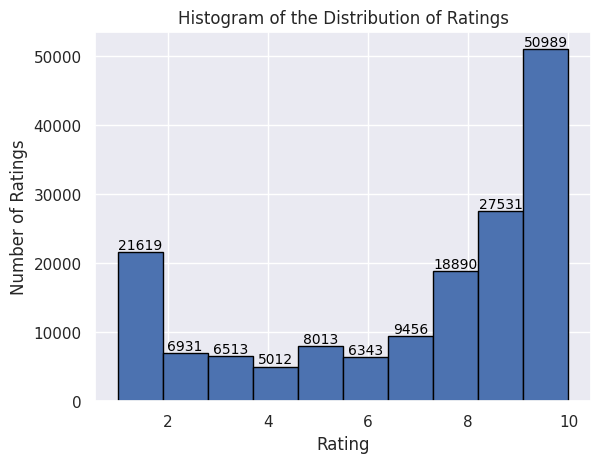

In [14]:
values, bins, bars = plt.hist(df['rating'], edgecolor = 'black', range = [1, 10])
plt.title('Histogram of the Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.bar_label(bars, fontsize=10, color='black')
plt.show()

Finding the mean rating for each drug, organized by condition, and then sorting table in descending order by rating 

In [15]:
df.groupby(['condition','drugName'])['rating'].mean().sort_values(ascending = False)

condition                  drugName        
Not Listed / Othe          Levocetirizine      10.0
Malaria Prevention         Pyrimethamine       10.0
Hyperthyroidism            Pima                10.0
                           Potassium iodide    10.0
                           Tapazole            10.0
                                               ... 
Pain                       Ziconotide           1.0
Multiple Myeloma           Dexamethasone        1.0
                           Carfilzomib          1.0
Severe Mood Dysregulation  Methylphenidate      1.0
Inflammatory Conditions    Medrol               1.0
Name: rating, Length: 8490, dtype: float64

Confirming that the ratings look right (i.e. have a few decimal points) by specifically looking at drugs listed under 'Birth Control' condition

In [16]:
df.groupby(['condition','drugName'])['rating'].mean()['Birth Control']

drugName
Alesse                   5.434783
Altavera                 6.428571
Alyacen 1 / 35           4.666667
Amethia                  6.625000
Amethia Lo               2.000000
                           ...   
Zarah                    6.583333
Zenchent                 8.000000
Zovia                    5.666667
Zovia 1 / 35             6.200000
depo-subQ provera 104    1.000000
Name: rating, Length: 172, dtype: float64

Looking into number of reviews that each unique ID has, confirming that each unique ID only has 1 review

In [17]:
df.groupby(['uniqueID'])['review'].count().sort_values(ascending = False)

uniqueID
2         1
154433    1
154421    1
154424    1
154425    1
         ..
77146     1
77147     1
77148     1
77149     1
232291    1
Name: review, Length: 161297, dtype: int64

Counting the number of unique IDs

In [18]:
df['uniqueID'].nunique()

161297

In [19]:
max(df['rating'].values)

10

In [20]:
min(df['rating'].values)

1

## Pre-Processing (Train Data)

In [21]:
# Function removes NAs and changes date to datetime type

def na_datatime(df):
    clean_df = df[df['condition'].notna()]
    clean_df.loc[:, 'date'] = clean_df['date'].apply(pd.to_datetime).dt.date
    return clean_df

Removing Na Values from the condition column because we did not want to assume a condition a medication was used for

Changing Data to datetime

In [22]:
clean_df = na_datatime(df)

/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [23]:
clean_df_test = na_datatime(df_test)

Confirming that the rows with missing values have been removed

In [24]:
df.shape[0] - clean_df.shape[0]

899

In [25]:
print(type(clean_df['date'].iloc[0])) 

<class 'datetime.date'>


In [26]:
def clean_reviews(review): 
    # Removing apostrophes
    apostroph = review.str.replace('&#039;', '')

    # Making all letters lowercase
    lower = apostroph.apply(str.lower)

    # Removing Unicode Characters (in case there is any) (eliminate the punctuation, URL, and @) 
    uni = lower.str.replace(r'(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?','', regex=True)

    #df["text"] =  df.text.str.replace('[^\x00-\x7F]','') this also removes nonascii characters

    # Removing the leading and trailing whitespaces
    whitesp = uni.str.replace(r'^\s+|\s+?$','')

    return whitesp


In [27]:
clean_df['review'] = clean_reviews(clean_df['review'])

clean_df['review']

/tmp/ipykernel_4035/34904853.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  whitesp = uni.str.replace(r'^\s+|\s+?$','')
/tmp/ipykernel_4035/2064659947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['review'] = clean_reviews(clean_df['review'])


0         it has no side effect i take it in combination...
1         my son is halfway through his fourth week of i...
2         i used to take another oral contraceptive whic...
3         this is my first time using any form of birth ...
4         suboxone has completely turned my life around ...
                                ...                        
161292    i wrote my first report in midoctober of 2014 ...
161293    i was given this in iv before surgey i immedia...
161294    limited improvement after 4 months developed b...
161295    ive been on thyroid medication 49 years i spen...
161296    ive had chronic constipation all my adult life...
Name: review, Length: 160398, dtype: object

In [28]:
clean_df_test['review'] = clean_reviews(clean_df_test['review'])

/tmp/ipykernel_4035/34904853.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  whitesp = uni.str.replace(r'^\s+|\s+?$','')
/tmp/ipykernel_4035/1265370811.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df_test['review'] = clean_reviews(clean_df_test['review'])


Cleaning up spelling errors (ran for 13 minutes and didn't finish) 

In [29]:
# from textblob.en import Spelling        
# from textblob import TextBlob
# corrected_reviews = []
# for i in clean_df['review']: 
#     r = TextBlob(i)
#     corr = r.correct()
#     corrected_reviews.append(corr)



Removing stop words from the reviews

In [30]:
#Removed using a list of values since 
stop_words = set(["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "between", "into", "through", "during", "before", "after", "to", "from", "over", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "other", "some", "such", "nor", "only", "own", "same", "so", "very", "s", "t", "can", "will", "just", "don", "should", "now"] )
clean_df['review_stop'] = clean_df['review'].apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))

/tmp/ipykernel_4035/2558659386.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['review_stop'] = clean_df['review'].apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))


In [31]:
clean_df_test['review_stop'] = clean_df_test['review'].apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))

/tmp/ipykernel_4035/2137053205.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df_test['review_stop'] = clean_df_test['review'].apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))


In [32]:
#clean_df['review_stop']

In [33]:
clean_df['review']

0         it has no side effect i take it in combination...
1         my son is halfway through his fourth week of i...
2         i used to take another oral contraceptive whic...
3         this is my first time using any form of birth ...
4         suboxone has completely turned my life around ...
                                ...                        
161292    i wrote my first report in midoctober of 2014 ...
161293    i was given this in iv before surgey i immedia...
161294    limited improvement after 4 months developed b...
161295    ive been on thyroid medication 49 years i spen...
161296    ive had chronic constipation all my adult life...
Name: review, Length: 160398, dtype: object

Removing numbers from the reviews

In [34]:
#clean_df['review_stop'] = clean_df['review_stop'].str.replace('\d+ ', '').str.replace('\d+', '')

If something <=4 it's a negative (labeled as -1), if it >5 it is a positive review (labeled as 1)

In [35]:
positive_negative_review = {
    1:0,
    2:0,
    3:0,
    4:0,
    5:-1,
    6:-1,
    7:1,
    8:1,
    9:1,
    10:1
}

In [36]:
clean_df['rating_sentiment'] = clean_df['rating'].replace(positive_negative_review)

/tmp/ipykernel_4035/1508826735.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['rating_sentiment'] = clean_df['rating'].replace(positive_negative_review)


In [37]:
clean_df_test['rating_sentiment'] = clean_df_test['rating'].replace(positive_negative_review)

/tmp/ipykernel_4035/19004427.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df_test['rating_sentiment'] = clean_df_test['rating'].replace(positive_negative_review)


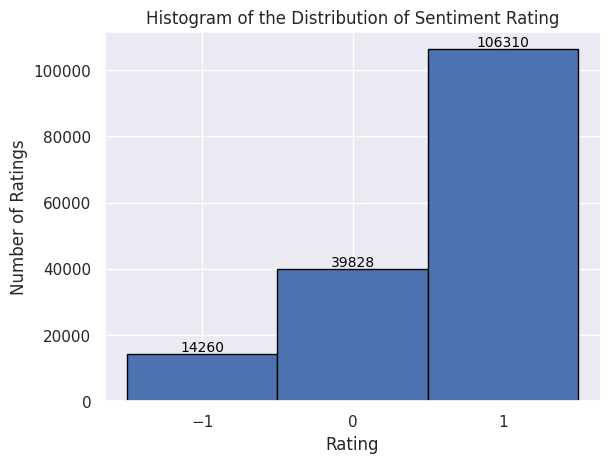

In [38]:
values1, bins1, bars1 = plt.hist(clean_df['rating_sentiment'], edgecolor = 'black', bins=[-1.5,-0.5,0.5,1.5])
plt.title('Histogram of the Distribution of Sentiment Rating')
plt.xticks((-1,0,1))
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.bar_label(bars1, fontsize=10, color='black')
plt.show()

Word cloud for positive and negative reviews

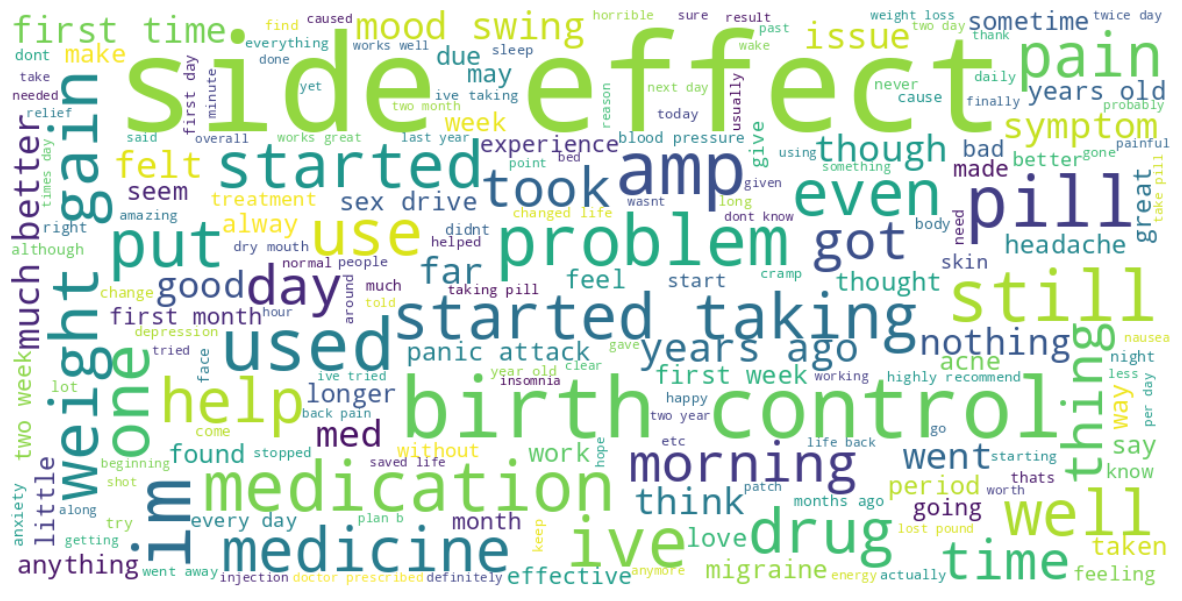

In [39]:
#Positive sentiment cloud
df_cloud_pos = clean_df.loc[clean_df.rating_sentiment == 1, 'review_stop']
cloud = " ".join(df_cloud_pos)

wordcloud = WordCloud(width = 1000, height = 500, background_color = 'white').generate(cloud)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

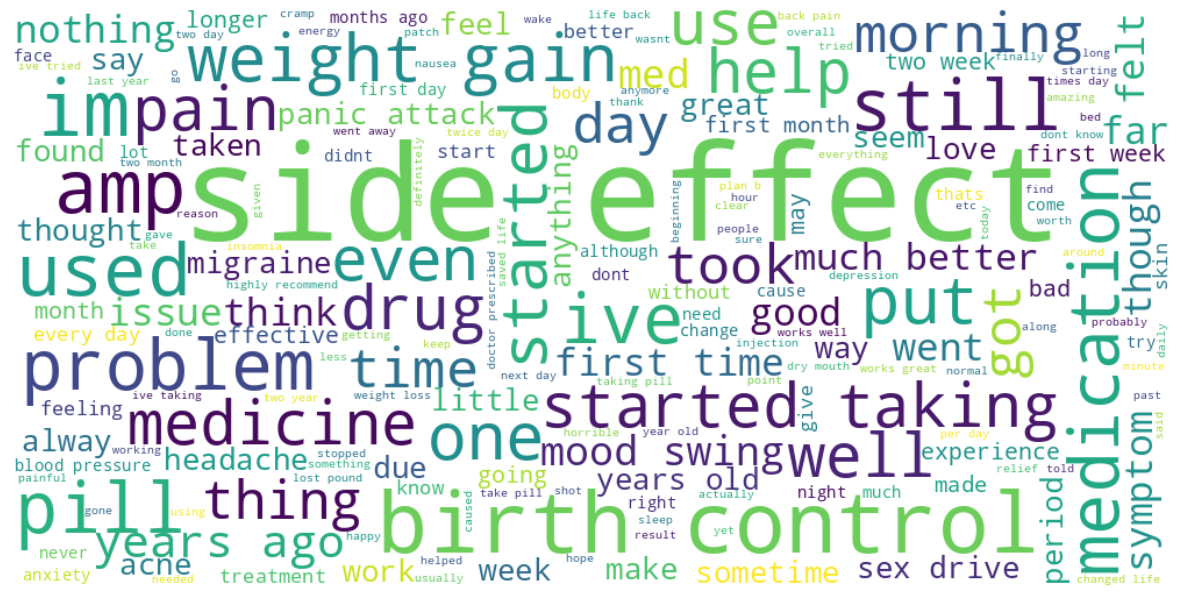

In [40]:
#negative sentiment cloud
df_cloud_neg = clean_df.loc[clean_df.rating_sentiment == 0, 'review_stop']
neg_cloud = " ".join(df_cloud_pos)

wordcloud = WordCloud(width = 1000, height = 500, background_color = 'white').generate(neg_cloud)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

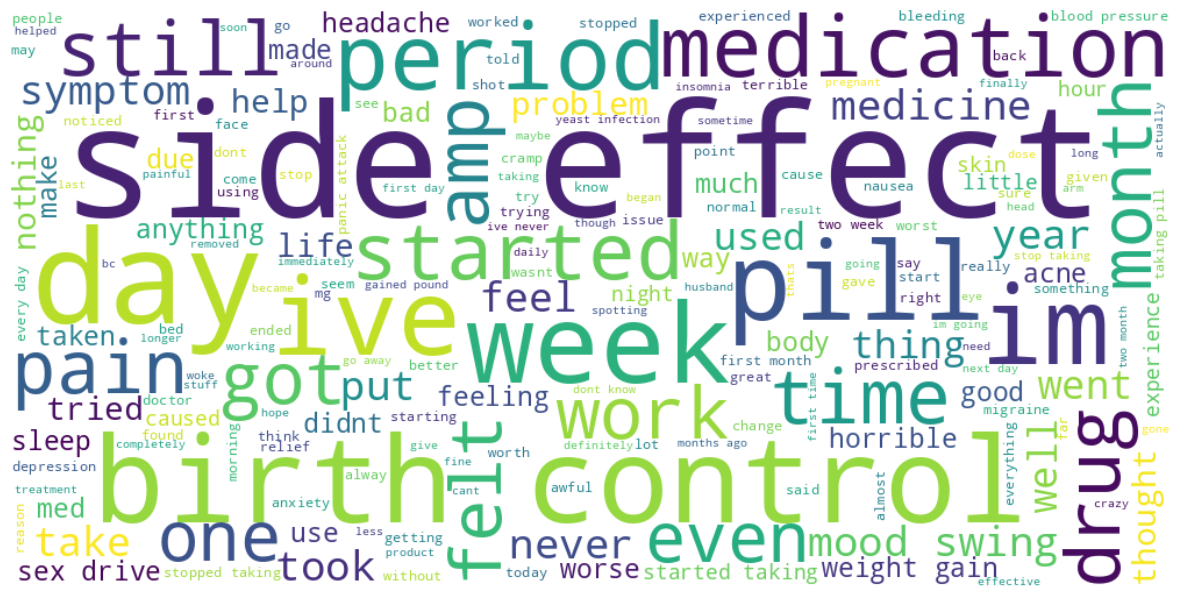

In [41]:
#very negative sentiment cloud
df_cloud_neg = clean_df.loc[clean_df.rating_sentiment == 0, 'review_stop']
vneg_cloud = " ".join(df_cloud_neg)

wordcloud = WordCloud(width = 1000, height = 500, background_color = 'white').generate(vneg_cloud)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

In [42]:
# # Create a list of lengths for training examples with a positive label.
# text_lengths= [len(x) for (i, x) in enumerate(df[])]

# # The histogram function can take a list of inputs and corresponding labels.
# plt.hist([text_lengths_pos, text_lengths_neg], bins=20, range=(0, 1000),
#          label=['positive', 'negative'])
# plt.legend()
# plt.show()

# # Also check the longest reviews.
# print('Longest positive review:', max(text_lengths_pos))
# print('Longest negative review:', max(text_lengths_neg))

In [43]:
clean_df = clean_df[(clean_df['rating_sentiment'] != -1)]
clean_df


,uniqueID,drugName,condition,review,rating,date,usefulCount,review_stop,rating_sentiment
0,206461,Valsartan,Left Ventricular Dysfunction,it has no side effect i take it in combination...,9,2012-05-20,27,no side effect take in combination bystolic 5 ...,1
1,95260,Guanfacine,ADHD,my son is halfway through his fourth week of i...,8,2010-04-27,192,son halfway fourth week intuniv became concern...,1
3,138000,Ortho Evra,Birth Control,this is my first time using any form of birth ...,8,2015-11-03,10,first time using form birth control im glad we...,1
4,35696,Buprenorphine / naloxone,Opiate Dependence,suboxone has completely turned my life around ...,9,2016-11-27,37,suboxone completely turned life around feel he...,1
5,155963,Cialis,Benign Prostatic Hyperplasia,2nd day on 5mg started to work with rock hard ...,2,2015-11-28,43,2nd day on 5mg started work rock hard erection...,0
...,...,...,...,...,...,...,...,...,...
161292,191035,Campral,Alcohol Dependence,i wrote my first report in midoctober of 2014 ...,10,2015-05-31,125,wrote first report in midoctober 2014 not alco...,1
161293,127085,Metoclopramide,Nausea/Vomiting,i was given this in iv before surgey i immedia...,1,2011-11-01,34,given in iv surgey immediately became anxious ...,0
161294,187382,Orencia,Rheumatoid Arthritis,limited improvement after 4 months developed b...,2,2014-03-15,35,limited improvement 4 months developed bad ras...,0
161295,47128,Thyroid desiccated,Underactive Thyroid,ive been on thyroid medication 49 years i spen...,10,2015-09-19,79,ive on thyroid medication 49 years spent first...,1


In [44]:
clean_df_test = clean_df_test[(clean_df_test['rating_sentiment'] != -1)]
clean_df_test

,uniqueID,drugName,condition,review,rating,date,usefulCount,review_stop,rating_sentiment
0,163740,Mirtazapine,Depression,ive tried a few antidepressants over the years...,10,2012-02-28,22,ive tried few antidepressants years citalopram...,1
1,206473,Mesalamine,"Crohn's Disease, Maintenance",my son has crohns disease and has done very we...,8,2009-05-17,17,son crohns disease done well on asacol no comp...,1
2,159672,Bactrim,Urinary Tract Infection,quick reduction of symptoms,9,2017-09-29,3,quick reduction symptoms,1
3,39293,Contrave,Weight Loss,contrave combines drugs that were used for alc...,9,2017-03-05,35,contrave combines drugs used alcohol smoking o...,1
4,97768,Cyclafem 1 / 35,Birth Control,i have been on this birth control for one cycl...,9,2015-10-22,4,on birth control one cycle reading reviews on ...,1
...,...,...,...,...,...,...,...,...,...
53761,159999,Tamoxifen,"Breast Cancer, Prevention",i have taken tamoxifen for 5 years side effect...,10,2014-09-13,43,taken tamoxifen 5 years side effects severe sw...,1
53762,140714,Escitalopram,Anxiety,ive been taking lexapro escitaploprgram since ...,9,2016-10-08,11,ive taking lexapro escitaploprgram since febru...,1
53763,130945,Levonorgestrel,Birth Control,im married 34 years old and i have no kids tak...,8,2010-11-15,7,im married 34 years old no kids taking pill ha...,1
53764,47656,Tapentadol,Pain,i was prescribed nucynta for severe neckshould...,1,2011-11-28,20,prescribed nucynta severe neckshoulder pain ta...,0


## Stemming (trim the ending off of words)

In [45]:
from nltk.stem.snowball import SnowballStemmer

In [46]:
stemmer = SnowballStemmer('english')

In [47]:
clean_df['review_stemmed'] = clean_df.review_stop.map(lambda x: ''.join([stemmer.stem(y) for y in x]))

In [48]:
clean_df_test['review_stemmed'] = clean_df_test.review_stop.map(lambda x: ''.join([stemmer.stem(y) for y in x]))

## Splitting test set further into test and validation sets

In [49]:
# splitting test data
X_test = clean_df_test['review_stemmed'].tolist()
Y_test = clean_df_test['rating_sentiment'].tolist()

In [50]:
X_validation, X_test, Y_validation, Y_test = train_test_split(X_test,Y_test, random_state=104, test_size=0.25, shuffle=True)

# Tokenize and Pad Train Data

In [51]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

In [52]:
list_cleandf2 = clean_df['review_stemmed'].tolist()

In [53]:
list_cleandf3 = clean_df_test['review_stemmed'].tolist()

In [54]:
list_cleandf4 = X_validation

In [55]:
tokenizer = Tokenizer(num_words = 150, oov_token = True)
tokenizer.fit_on_texts(list_cleandf2)

In [56]:
sequences = tokenizer.texts_to_sequences(list_cleandf2)
sequences2 = tokenizer.texts_to_sequences(list_cleandf3)
sequences3 = tokenizer.texts_to_sequences(list_cleandf4)

In [57]:
word_index = tokenizer.word_index
print('Size of training vocabulary:', len(word_index))

Size of training vocabulary: 84706


In [58]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenized_and_padded = pad_sequences(sequences, maxlen=150, padding='post')
tokenized_and_padded2 = pad_sequences(sequences2, maxlen=150, padding='post')
tokenized_and_padded3 = pad_sequences(sequences3, maxlen=150, padding='post')

In [59]:
len(tokenized_and_padded)

146138

In [60]:
# Add tokenized & padded data to cleaned dataframe as new column
clean_df['tokenized'] = tokenized_and_padded.tolist()
clean_df

,uniqueID,drugName,condition,review,rating,date,usefulCount,review_stop,rating_sentiment,review_stemmed,tokenized
0,206461,Valsartan,Left Ventricular Dysfunction,it has no side effect i take it in combination...,9,2012-05-20,27,no side effect take in combination bystolic 5 ...,1,no side effect take in combination bystolic 5 ...,"[5, 8, 132, 13, 3, 1, 1, 92, 91, 1, 1, 0, 0, 0..."
1,95260,Guanfacine,ADHD,my son is halfway through his fourth week of i...,8,2010-04-27,192,son halfway fourth week intuniv became concern...,1,son halfway fourth week intuniv became concern...,"[1, 1, 1, 34, 1, 1, 1, 1, 84, 34, 17, 9, 1, 87..."
3,138000,Ortho Evra,Birth Control,this is my first time using any form of birth ...,8,2015-11-03,10,first time using form birth control im glad we...,1,first time using form birth control im glad we...,"[14, 22, 111, 1, 81, 63, 7, 1, 55, 1, 2, 1, 16..."
4,35696,Buprenorphine / naloxone,Opiate Dependence,suboxone has completely turned my life around ...,9,2016-11-27,37,suboxone completely turned life around feel he...,1,suboxone completely turned life around feel he...,"[1, 1, 1, 43, 1, 24, 1, 7, 1, 1, 147, 1, 3, 1,..."
5,155963,Cialis,Benign Prostatic Hyperplasia,2nd day on 5mg started to work with rock hard ...,2,2015-11-28,43,2nd day on 5mg started work rock hard erection...,0,2nd day on 5mg started work rock hard erection...,"[1, 6, 2, 1, 17, 58, 1, 1, 1, 1, 1, 1, 1, 1, 1..."
...,...,...,...,...,...,...,...,...,...,...,...
161292,191035,Campral,Alcohol Dependence,i wrote my first report in midoctober of 2014 ...,10,2015-05-31,125,wrote first report in midoctober 2014 not alco...,1,wrote first report in midoctober 2014 not alco...,"[1, 14, 1, 3, 1, 1, 4, 1, 45, 1, 1, 1, 133, 29..."
161293,127085,Metoclopramide,Nausea/Vomiting,i was given this in iv before surgey i immedia...,1,2011-11-01,34,given in iv surgey immediately became anxious ...,0,given in iv surgey immediately became anxious ...,"[1, 3, 1, 1, 1, 1, 1, 93, 4, 1, 48, 1, 1, 1, 1..."
161294,187382,Orencia,Rheumatoid Arthritis,limited improvement after 4 months developed b...,2,2014-03-15,35,limited improvement 4 months developed bad ras...,0,limited improvement 4 months developed bad ras...,"[1, 1, 77, 16, 1, 47, 1, 1, 1, 1, 35, 0, 0, 0,..."
161295,47128,Thyroid desiccated,Underactive Thyroid,ive been on thyroid medication 49 years i spen...,10,2015-09-19,79,ive on thyroid medication 49 years spent first...,1,ive on thyroid medication 49 years spent first...,"[11, 2, 1, 35, 1, 10, 1, 14, 1, 2, 1, 1, 1, 1,..."


In [61]:
# Extract tokenized data and rating sentiment columns
train_data = clean_df[['tokenized', 'rating_sentiment']]
train_data.head()

,tokenized,rating_sentiment
0,"[5, 8, 132, 13, 3, 1, 1, 92, 91, 1, 1, 0, 0, 0...",1
1,"[1, 1, 1, 34, 1, 1, 1, 1, 84, 34, 17, 9, 1, 87...",1
3,"[14, 22, 111, 1, 81, 63, 7, 1, 55, 1, 2, 1, 16...",1
4,"[1, 1, 1, 43, 1, 24, 1, 7, 1, 1, 147, 1, 3, 1,...",1
5,"[1, 6, 2, 1, 17, 58, 1, 1, 1, 1, 1, 1, 1, 1, 1...",0


In [62]:
clean_df_test['tokenized'] = tokenized_and_padded2.tolist()
test_data_clean = clean_df_test[['tokenized', 'rating_sentiment']]
test_data_clean.head()

,tokenized,rating_sentiment
0,"[11, 73, 69, 1, 10, 1, 1, 1, 1, 122, 86, 1, 10...",1
1,"[1, 1, 1, 1, 62, 2, 1, 5, 1, 1, 5, 8, 15, 144,...",1
2,"[1, 1, 121, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1
3,"[1, 1, 1, 88, 1, 1, 1, 1, 1, 1, 41, 2, 37, 1, ...",1
4,"[2, 81, 63, 30, 1, 1, 1, 2, 1, 1, 81, 1, 1, 1,...",1


In [63]:
clean_validation = tokenized_and_padded3.tolist()
validation_df = pd.DataFrame(
    {'Tokenized': clean_validation,
     'rating_sentiment': Y_validation,
    })

validation_df

,Tokenized,rating_sentiment
0,"[65, 105, 1, 1, 1, 1, 135, 49, 1, 11, 1, 41, 1...",1
1,"[11, 2, 1, 34, 1, 1, 1, 24, 18, 1, 1, 1, 65, 1...",1
2,"[1, 133, 1, 108, 1, 135, 1, 1, 67, 2, 110, 1, ...",1
3,"[11, 1, 1, 1, 1, 120, 1, 1, 1, 33, 1, 1, 1, 1,...",1
4,"[18, 1, 1, 55, 2, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0...",1
...,...,...
36503,"[1, 1, 1, 1, 43, 5, 28, 1, 1, 1, 1, 1, 1, 1, 1...",1
36504,"[38, 1, 1, 63, 1, 1, 1, 107, 0, 0, 0, 0, 0, 0,...",1
36505,"[1, 1, 43, 1, 68, 1, 1, 1, 95, 1, 1, 52, 1, 72...",1
36506,"[1, 1, 123, 1, 90, 11, 2, 39, 45, 1, 1, 1, 1, ...",1


# TF-IDF (Vectorizer)

"The problem with the above two approaches is that common words that occur in similar frequencies in all documents (i.e., words that are not particularly unique to the text samples in the dataset) are not penalized. For example, words like “a” will occur very frequently in all texts. So a higher token count for “the” than for other more meaningful words is not very useful." https://developers.google.com/machine-learning/guides/text-classification/step-3

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

In [65]:
tf_x_train = vectorizer.fit_transform(clean_df['review_stemmed'])

In [66]:
tf_x_test = vectorizer.transform(clean_df_test['review_stemmed'])
tf_x_test

<48678x84673 sparse matrix of type '<class 'numpy.float64'>'
	with 1964281 stored elements in Compressed Sparse Row format>

In [67]:
test_vector_tfidfvectorizer2 = tf_x_test[0] 

In [68]:
tfidf_df = pd.DataFrame(test_vector_tfidfvectorizer2.T.todense(), index=vectorizer.get_feature_names_out(), columns=["tfidf"]) 
tfidf_df.sort_values(by=["tfidf"],ascending=False)

,tfidf
mirtazapine,0.425387
saved,0.297201
45mg,0.251428
fluoxetine,0.213755
amitriptyline,0.204397
...,...
durg,0.000000
durezol,0.000000
duress,0.000000
duregesic,0.000000


In [69]:
first_vector_tfidfvectorizer = tf_x_train[0] 

In [70]:
tfidf_df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=vectorizer.get_feature_names_out(), columns=["tfidf"]) 
tfidf_df.sort_values(by=["tfidf"],ascending=False)

,tfidf
fish,0.507705
bystolic,0.489469
oil,0.424565
combination,0.360090
effect,0.239951
...,...
durationpowerful,0.000000
durationeasier,0.000000
duration,0.000000
duramorph,0.000000


# Model 1 (Linear SVC)

In [71]:
# Separate training data into reviews and labels
X_train = train_data['tokenized'].tolist()
Y_train = train_data['rating_sentiment'].tolist()
print('First training example data:', X_train[0])
print('First training example label:', Y_train[0])

First training example data: [5, 8, 132, 13, 3, 1, 1, 92, 91, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
First training example label: 1


In [72]:
tf_x_validation = vectorizer.transform(X_validation)
tf_x_validation

<36508x84673 sparse matrix of type '<class 'numpy.float64'>'
	with 1476741 stored elements in Compressed Sparse Row format>

In [73]:
clf = LinearSVC(random_state=0)

In [74]:
clf.fit(tf_x_train, Y_train)

LinearSVC(random_state=0)

In [75]:
y_validation_pred = clf.predict(tf_x_validation)

In [76]:
report = classification_report(Y_validation, y_validation_pred,output_dict=True)

In [77]:
report

{'0': {'precision': 0.8330065359477125,
  'recall': 0.7629452259802454,
  'f1-score': 0.7964380565536634,
  'support': 10023},
 '1': {'precision': 0.913056206088993,
  'recall': 0.9421181801019445,
  'f1-score': 0.9273595599576311,
  'support': 26485},
 'accuracy': 0.8929275775172565,
 'macro avg': {'precision': 0.8730313710183527,
  'recall': 0.8525317030410949,
  'f1-score': 0.8618988082556472,
  'support': 36508},
 'weighted avg': {'precision': 0.8910791642399173,
  'recall': 0.8929275775172565,
  'f1-score': 0.8914160344668354,
  'support': 36508}}

Accuracy of Linear SVC: 89.3% 

### Test data

In [78]:
tf_x_test = vectorizer.transform(X_test)
tf_x_test

<12170x84673 sparse matrix of type '<class 'numpy.float64'>'
	with 487540 stored elements in Compressed Sparse Row format>

In [79]:
y_test_pred = clf.predict(tf_x_test)

In [80]:
test_report = classification_report(Y_test, y_test_pred,output_dict=True)
test_report

{'0': {'precision': 0.8389635946211873,
  'recall': 0.7512481644640235,
  'f1-score': 0.7926867059188101,
  'support': 3405},
 '1': {'precision': 0.9071373752877974,
  'recall': 0.9439817455790074,
  'f1-score': 0.9251928882925193,
  'support': 8765},
 'accuracy': 0.8900575184880855,
 'macro avg': {'precision': 0.8730504849544923,
  'recall': 0.8476149550215155,
  'f1-score': 0.8589397971056647,
  'support': 12170},
 'weighted avg': {'precision': 0.8880632813543703,
  'recall': 0.8900575184880855,
  'f1-score': 0.8881194658617485,
  'support': 12170}}

# Model 2 (Logistic Regression)

In [81]:
clf = LogisticRegression(max_iter=1000,solver='saga')

In [82]:
clf.fit(tf_x_train,Y_train)

LogisticRegression(max_iter=1000, solver='saga')

In [83]:
y_validation_pred = clf.predict(tf_x_validation)

In [84]:
report1 = classification_report(Y_validation, y_validation_pred,output_dict=True)

In [85]:
report1

{'0': {'precision': 0.8252599243856332,
  'recall': 0.6968971365858525,
  'f1-score': 0.755666143776708,
  'support': 10023},
 '1': {'precision': 0.8916702324917986,
  'recall': 0.9441570700396451,
  'f1-score': 0.9171633442755232,
  'support': 26485},
 'accuracy': 0.8762736934370549,
 'macro avg': {'precision': 0.8584650784387159,
  'recall': 0.8205271033127488,
  'f1-score': 0.8364147440261156,
  'support': 36508},
 'weighted avg': {'precision': 0.8734377760946227,
  'recall': 0.8762736934370549,
  'f1-score': 0.8728254884466741,
  'support': 36508}}

Accuracy of logistic regression: 87.6

# Model 3 (Binary Decision Tree Classifier)

In [87]:
from sklearn.tree import DecisionTreeClassifier

# Create Decision Tree classifer object
dt = DecisionTreeClassifier(random_state=1)

# Train Decision Tree Classifer
dt = dt.fit(tf_x_train, Y_train)

# Predict the response for validation dataset
y_pred = dt.predict(tf_x_validation)

In [88]:
from sklearn import metrics
print("Accuracy:", metrics.accuracy_score(Y_validation, y_pred))

Accuracy: 0.8935575764216063


In [89]:
report2 = classification_report(Y_validation, y_pred, output_dict=True)

In [90]:
report2

{'0': {'precision': 0.8076190476190476,
  'recall': 0.8037513718447571,
  'f1-score': 0.8056805680568058,
  'support': 10023},
 '1': {'precision': 0.9258659028379753,
  'recall': 0.9275438927694921,
  'f1-score': 0.9267041382172092,
  'support': 26485},
 'accuracy': 0.8935575764216063,
 'macro avg': {'precision': 0.8667424752285114,
  'recall': 0.8656476323071246,
  'f1-score': 0.8661923531370075,
  'support': 36508},
 'weighted avg': {'precision': 0.8934021077832116,
  'recall': 0.8935575764216063,
  'f1-score': 0.8934780167173263,
  'support': 36508}}

In [91]:
#from sklearn import tree
#from IPython.display import SVG
#from graphviz import Source
#from IPython.display import display

#graph = Source(
#    tree.export_graphviz(
#        dt,
#        out_file=None,
#        feature_names=vectorizer.get_feature_names(),
#        class_names=['0', '1'],
#        filled = True)
#)
#display(SVG(graph.pipe(format='svg')))

#Error:
#CellOutputSizeError: The block's output is too large.

## Test data

In [92]:
# Predict the response for test dataset
y_pred = dt.predict(tf_x_test)
print("Accuracy:", metrics.accuracy_score(Y_test, y_pred))

Accuracy: 0.8922760887428102


In [93]:
test_report2 = classification_report(Y_test, y_pred, output_dict=True)
test_report2

{'0': {'precision': 0.8163141993957704,
  'recall': 0.7935389133627019,
  'f1-score': 0.8047654504839911,
  'support': 3405},
 '1': {'precision': 0.9206546275395033,
  'recall': 0.9306332002281803,
  'f1-score': 0.9256170212765957,
  'support': 8765},
 'accuracy': 0.8922760887428102,
 'macro avg': {'precision': 0.8684844134676368,
  'recall': 0.8620860567954411,
  'f1-score': 0.8651912358802933,
  'support': 12170},
 'weighted avg': {'precision': 0.8914615989586151,
  'recall': 0.8922760887428102,
  'f1-score': 0.8918044001961669,
  'support': 12170}}

# Model 4 (Embeddings)

In [94]:
X_train_emb = np.array(train_data['tokenized'].tolist())
Y_train_emb = np.array(train_data['rating_sentiment'].tolist())
X_validation_array = np.array(train_data['tokenized'].tolist())
Y_validation_array = np.array(train_data['rating_sentiment'].tolist())

In [95]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout


#Building Embeddings Model
def embeddings_model_1(vocab_size=150, sequence_length=150, embedding_dim=2):
    """Build a tf.keras model using embeddings."""
    # Clear session and remove randomness.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=sequence_length,
        name="embedding"))
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    model.add(tf.keras.layers.Dense(
        units=1,                    
        activation='sigmoid'         
        ))
    model.compile(loss='binary_crossentropy', 
                optimizer='adam',
                metrics=['accuracy'])
    return model

In [96]:
model1 = embeddings_model_1(vocab_size=150, sequence_length=150, embedding_dim=2)
model1.summary()                              

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 2)            300       
                                                                 
 global_average_pooling1d (G  (None, 2)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 303
Trainable params: 303
Non-trainable params: 0
_________________________________________________________________
2023-04-18 17:08:25.960011: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-18 17:08:25.960039: W tensor

In [97]:
tf.random.set_seed(1)
np.random.seed(1)
history1 = model1.fit(
    X_train_emb, 
    Y_train_emb,
    validation_data=(X_validation_array, Y_validation_array), 
    epochs=5)

Epoch 1/5
4567/4567 [==============================] - 7s 1ms/step - loss: 0.5805 - accuracy: 0.7275 - val_loss: 0.5647 - val_accuracy: 0.7275
Epoch 2/5
4567/4567 [==============================] - 6s 1ms/step - loss: 0.5439 - accuracy: 0.7295 - val_loss: 0.5205 - val_accuracy: 0.7374
Epoch 3/5
4567/4567 [==============================] - 6s 1ms/step - loss: 0.5034 - accuracy: 0.7514 - val_loss: 0.4912 - val_accuracy: 0.7646
Epoch 4/5
4567/4567 [==============================] - 6s 1ms/step - loss: 0.4865 - accuracy: 0.7675 - val_loss: 0.4831 - val_accuracy: 0.7709
Epoch 5/5
4567/4567 [==============================] - 6s 1ms/step - loss: 0.4822 - accuracy: 0.7707 - val_loss: 0.4808 - val_accuracy: 0.7716


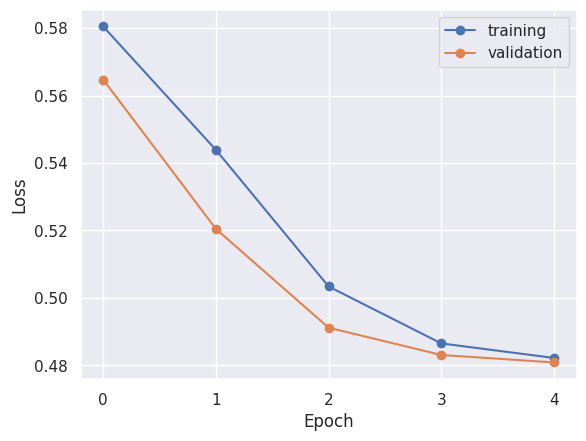

In [98]:
# plot function obtained from assignment 9 for 207 class

def plot_history(history):
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(range(0, len(history['loss'] + 1)))
    plt.plot(history['loss'], label="training", marker='o')
    plt.plot(history['val_loss'], label="validation", marker='o')
    plt.legend()
    plt.show()


history1 = pd.DataFrame(history1.history)
plot_history(history1)

Second Embeddings Model (Optimizer "SGD")

In [99]:
def embeddings_model_2(vocab_size=150, sequence_length=150, embedding_dim=2):
    """Build a tf.keras model using embeddings."""
    # Clear session and remove randomness.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=sequence_length))
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    model.add(tf.keras.layers.Dense(
        units=1,                    
        activation='sigmoid'         
        ))
    model.compile(loss='binary_crossentropy', 
                optimizer='SGD',
                metrics=['accuracy'])
    return model

In [100]:
model2 = embeddings_model_2(vocab_size=150, sequence_length=150, embedding_dim=2)
model2.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 2)            300       
                                                                 
 global_average_pooling1d (G  (None, 2)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 303
Trainable params: 303
Non-trainable params: 0
_________________________________________________________________


In [101]:
tf.random.set_seed(1)
np.random.seed(1)
history2 = model2.fit(
    X_train_emb, 
    Y_train_emb,
    validation_data=(X_validation_array, Y_validation_array), 
    epochs=5)

Epoch 1/5
4567/4567 [==============================] - 7s 2ms/step - loss: 0.5904 - accuracy: 0.7273 - val_loss: 0.5861 - val_accuracy: 0.7275
Epoch 2/5
4567/4567 [==============================] - 7s 1ms/step - loss: 0.5859 - accuracy: 0.7275 - val_loss: 0.5857 - val_accuracy: 0.7275
Epoch 3/5
4567/4567 [==============================] - 7s 1ms/step - loss: 0.5856 - accuracy: 0.7275 - val_loss: 0.5855 - val_accuracy: 0.7275
Epoch 4/5
4567/4567 [==============================] - 7s 1ms/step - loss: 0.5854 - accuracy: 0.7275 - val_loss: 0.5853 - val_accuracy: 0.7275
Epoch 5/5
4567/4567 [==============================] - 7s 1ms/step - loss: 0.5852 - accuracy: 0.7275 - val_loss: 0.5851 - val_accuracy: 0.7275


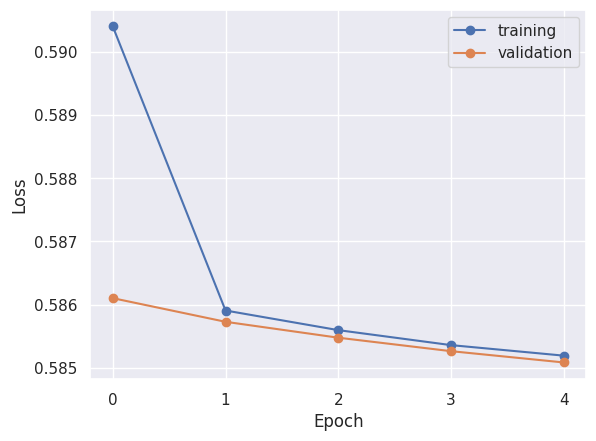

In [102]:
history2 = pd.DataFrame(history2.history)
plot_history(history2)

Model 3 using dropout regularization

In [131]:
#Building Embeddings Model
def embeddings_model_3(vocab_size=150, sequence_length=150, embedding_dim=2):
    """Build a tf.keras model using embeddings."""
    # Clear session and remove randomness.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=sequence_length))
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    model.add(tf.keras.layers.Dense(
        units=200,                    
        activation='relu'         
        ))
    # adding dropout regularization
    model.add(keras.layers.Dropout(rate=0.5))
    model.add(tf.keras.layers.Dense(
        units=1,                    
        activation='sigmoid'         
        ))
    model.compile(loss='binary_crossentropy', 
                optimizer='adam',
                metrics=['accuracy'])
    return model

In [132]:
model3 = embeddings_model_3(vocab_size=150, sequence_length=150, embedding_dim=2)
model3.summary()   

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 2)            300       
                                                                 
 global_average_pooling1d (G  (None, 2)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 200)               600       
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 1,101
Trainable params: 1,101
Non-trainable params: 0
______________________________________________________

In [133]:
tf.random.set_seed(1)
np.random.seed(1)
history3 = model3.fit(
    X_train_emb, 
    Y_train_emb,
    validation_data=(X_validation_array, Y_validation_array), 
    epochs=5)

Epoch 1/5
4567/4567 [==============================] - 8s 2ms/step - loss: 0.5167 - accuracy: 0.7540 - val_loss: 0.4789 - val_accuracy: 0.7720
Epoch 2/5
4567/4567 [==============================] - 8s 2ms/step - loss: 0.4825 - accuracy: 0.7723 - val_loss: 0.4789 - val_accuracy: 0.7774
Epoch 3/5
4567/4567 [==============================] - 7s 2ms/step - loss: 0.4804 - accuracy: 0.7732 - val_loss: 0.4740 - val_accuracy: 0.7760
Epoch 4/5
4567/4567 [==============================] - 8s 2ms/step - loss: 0.4775 - accuracy: 0.7754 - val_loss: 0.4722 - val_accuracy: 0.7777
Epoch 5/5
4567/4567 [==============================] - 8s 2ms/step - loss: 0.4761 - accuracy: 0.7750 - val_loss: 0.4707 - val_accuracy: 0.7789


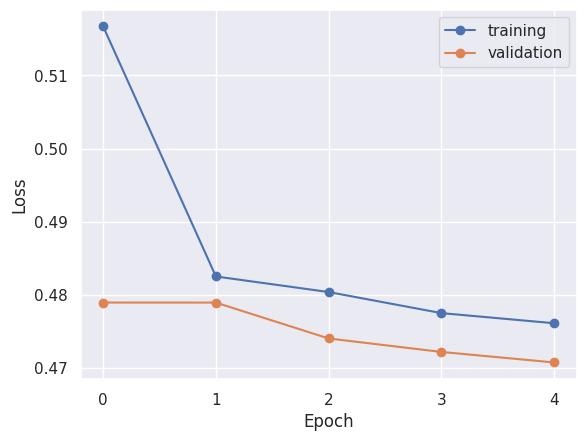

In [134]:
history3 = pd.DataFrame(history3.history)
plot_history(history3)

Model 4 ( adding more dense layers)

In [107]:
#Building Embeddings Model
def embeddings_model_4(vocab_size=150, sequence_length=150, embedding_dim=2):
    """Build a tf.keras model using embeddings."""
    # Clear session and remove randomness.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=sequence_length))
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    model.add(tf.keras.layers.Dense(
        units=8,                    
        activation='relu'         
        ))
    model.add(tf.keras.layers.Dense(
        units=1,                    
        activation='sigmoid'         
        ))
    model.compile(loss='binary_crossentropy', 
                optimizer='adam',
                metrics=['accuracy'])
    return model

In [108]:
model4 = embeddings_model_4(vocab_size=150, sequence_length=150, embedding_dim=2)
model4.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 2)            300       
                                                                 
 global_average_pooling1d (G  (None, 2)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 8)                 24        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 333
Trainable params: 333
Non-trainable params: 0
_________________________________________________________________


In [109]:
tf.random.set_seed(1)
np.random.seed(1)
history4 = model4.fit(
    X_train_emb, 
    Y_train_emb,
    validation_data=(X_validation_array, Y_validation_array), 
    epochs=5)

Epoch 1/5
4567/4567 [==============================] - 8s 2ms/step - loss: 0.5638 - accuracy: 0.7300 - val_loss: 0.5036 - val_accuracy: 0.7519
Epoch 2/5
4567/4567 [==============================] - 8s 2ms/step - loss: 0.4864 - accuracy: 0.7673 - val_loss: 0.4809 - val_accuracy: 0.7754
Epoch 3/5
4567/4567 [==============================] - 8s 2ms/step - loss: 0.4798 - accuracy: 0.7727 - val_loss: 0.4779 - val_accuracy: 0.7742
Epoch 4/5
4567/4567 [==============================] - 7s 1ms/step - loss: 0.4786 - accuracy: 0.7730 - val_loss: 0.4776 - val_accuracy: 0.7750
Epoch 5/5
4567/4567 [==============================] - 7s 1ms/step - loss: 0.4777 - accuracy: 0.7735 - val_loss: 0.4759 - val_accuracy: 0.7758


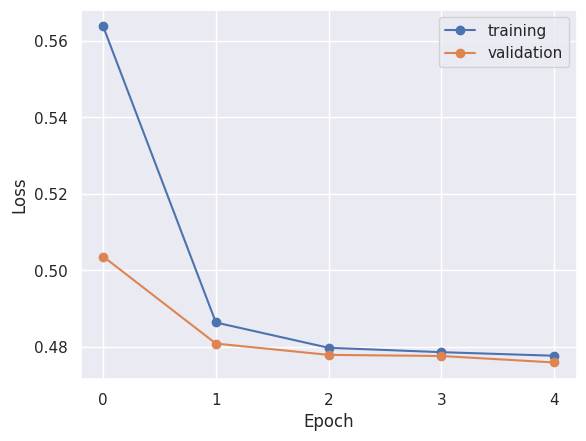

In [110]:
history4 = pd.DataFrame(history4.history)
plot_history(history4)

In [111]:
#Building Embeddings Model
def embeddings_model_5(vocab_size=150, sequence_length=150, embedding_dim=2):
    """Build a tf.keras model using embeddings."""
    # Clear session and remove randomness.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=sequence_length))
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    model.add(tf.keras.layers.Dense(
        units=16,                    
        activation='relu'         
        ))
    model.add(tf.keras.layers.Dense(
        units=1,                    
        activation='sigmoid'         
        ))
    model.compile(loss='binary_crossentropy', 
                optimizer='adam',
                metrics=['accuracy'])
    return model

In [112]:
model5 = embeddings_model_5(vocab_size=150, sequence_length=150, embedding_dim=2)
model5.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 2)            300       
                                                                 
 global_average_pooling1d (G  (None, 2)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                48        
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 365
Trainable params: 365
Non-trainable params: 0
_________________________________________________________________


In [113]:
tf.random.set_seed(1)
np.random.seed(1)
history5 = model5.fit(
    X_train_emb, 
    Y_train_emb,
    validation_data=(X_validation_array, Y_validation_array), 
    epochs=5)

Epoch 1/5
4567/4567 [==============================] - 7s 2ms/step - loss: 0.5481 - accuracy: 0.7370 - val_loss: 0.4864 - val_accuracy: 0.7667
Epoch 2/5
4567/4567 [==============================] - 7s 1ms/step - loss: 0.4821 - accuracy: 0.7710 - val_loss: 0.4800 - val_accuracy: 0.7759
Epoch 3/5
4567/4567 [==============================] - 7s 2ms/step - loss: 0.4794 - accuracy: 0.7731 - val_loss: 0.4777 - val_accuracy: 0.7739
Epoch 4/5
4567/4567 [==============================] - 7s 2ms/step - loss: 0.4789 - accuracy: 0.7729 - val_loss: 0.4776 - val_accuracy: 0.7742
Epoch 5/5
4567/4567 [==============================] - 7s 1ms/step - loss: 0.4786 - accuracy: 0.7728 - val_loss: 0.4775 - val_accuracy: 0.7747


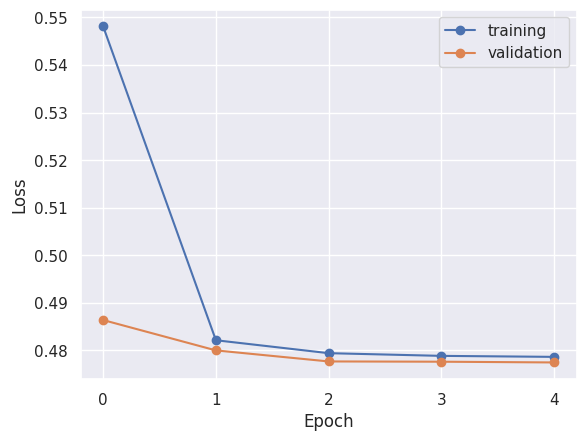

In [114]:
history5 = pd.DataFrame(history5.history)
plot_history(history5)

In [115]:
#Building Embeddings Model
def embeddings_model_6(vocab_size=150, sequence_length=150, embedding_dim=2):
    """Build a tf.keras model using embeddings."""
    # Clear session and remove randomness.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=sequence_length))
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    model.add(tf.keras.layers.Dense(
        units=32,                    
        activation='relu'         
        ))
    model.add(tf.keras.layers.Dense(
        units=1,                    
        activation='sigmoid'         
        ))
    model.compile(loss='binary_crossentropy', 
                optimizer='adam',
                metrics=['accuracy'])
    return model

In [116]:
model6 = embeddings_model_6(vocab_size=150, sequence_length=150, embedding_dim=2)
model6.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 2)            300       
                                                                 
 global_average_pooling1d (G  (None, 2)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                96        
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 429
Trainable params: 429
Non-trainable params: 0
_________________________________________________________________


In [117]:
tf.random.set_seed(1)
np.random.seed(1)
history6 = model6.fit(
    X_train_emb, 
    Y_train_emb,
    validation_data=(X_validation_array, Y_validation_array), 
    epochs=5)

Epoch 1/5
4567/4567 [==============================] - 7s 2ms/step - loss: 0.5397 - accuracy: 0.7418 - val_loss: 0.4827 - val_accuracy: 0.7699
Epoch 2/5
4567/4567 [==============================] - 7s 2ms/step - loss: 0.4807 - accuracy: 0.7721 - val_loss: 0.4796 - val_accuracy: 0.7774
Epoch 3/5
4567/4567 [==============================] - 7s 2ms/step - loss: 0.4779 - accuracy: 0.7743 - val_loss: 0.4749 - val_accuracy: 0.7758
Epoch 4/5
4567/4567 [==============================] - 7s 2ms/step - loss: 0.4749 - accuracy: 0.7762 - val_loss: 0.4725 - val_accuracy: 0.7785
Epoch 5/5
4567/4567 [==============================] - 7s 1ms/step - loss: 0.4734 - accuracy: 0.7771 - val_loss: 0.4715 - val_accuracy: 0.7789


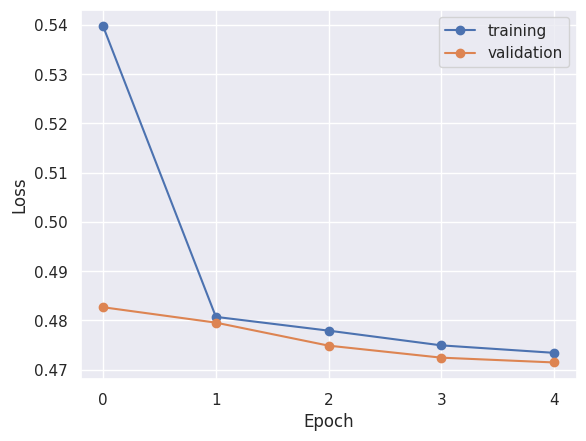

In [118]:
history6 = pd.DataFrame(history6.history)
plot_history(history6)

In [119]:
#Building Embeddings Model
def embeddings_model_7(vocab_size=150, sequence_length=150, embedding_dim=2):
    """Build a tf.keras model using embeddings."""
    # Clear session and remove randomness.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=sequence_length))
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    model.add(tf.keras.layers.Dense(
        units=8,                    
        activation='softmax'         
        ))
    model.add(tf.keras.layers.Dense(
        units=1,                    
        activation='sigmoid'         
        ))
    model.compile(loss='binary_crossentropy', 
                optimizer='adam',
                metrics=['accuracy'])
    return model

In [120]:
model7 = embeddings_model_7(vocab_size=150, sequence_length=150, embedding_dim=2)
model7.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 2)            300       
                                                                 
 global_average_pooling1d (G  (None, 2)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 8)                 24        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 333
Trainable params: 333
Non-trainable params: 0
_________________________________________________________________


In [121]:
tf.random.set_seed(1)
np.random.seed(1)
history7 = model7.fit(
    X_train_emb, 
    Y_train_emb,
    validation_data=(X_validation_array, Y_validation_array), 
    epochs=5)

Epoch 1/5
4567/4567 [==============================] - 8s 2ms/step - loss: 0.5904 - accuracy: 0.7136 - val_loss: 0.5706 - val_accuracy: 0.7275
Epoch 2/5
4567/4567 [==============================] - 7s 2ms/step - loss: 0.5312 - accuracy: 0.7382 - val_loss: 0.4964 - val_accuracy: 0.7627
Epoch 3/5
4567/4567 [==============================] - 7s 2ms/step - loss: 0.4868 - accuracy: 0.7685 - val_loss: 0.4816 - val_accuracy: 0.7729
Epoch 4/5
4567/4567 [==============================] - 7s 2ms/step - loss: 0.4805 - accuracy: 0.7722 - val_loss: 0.4791 - val_accuracy: 0.7744
Epoch 5/5
4567/4567 [==============================] - 7s 2ms/step - loss: 0.4790 - accuracy: 0.7734 - val_loss: 0.4781 - val_accuracy: 0.7742


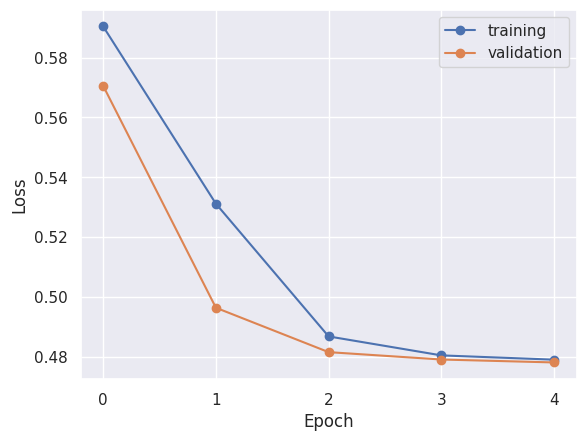

In [122]:
history7 = pd.DataFrame(history7.history)
plot_history(history7)

In [123]:
#Building Embeddings Model
def embeddings_model_8(vocab_size=150, sequence_length=150, embedding_dim=2):
    """Build a tf.keras model using embeddings."""
    # Clear session and remove randomness.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=sequence_length))
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    model.add(tf.keras.layers.Dense(
        units=16,                    
        activation='softmax'         
        ))
    model.add(tf.keras.layers.Dense(
        units=1,                    
        activation='sigmoid'         
        ))
    model.compile(loss='binary_crossentropy', 
                optimizer='adam',
                metrics=['accuracy'])
    return model

In [124]:
model8 = embeddings_model_8(vocab_size=150, sequence_length=150, embedding_dim=2)
model8.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 2)            300       
                                                                 
 global_average_pooling1d (G  (None, 2)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                48        
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 365
Trainable params: 365
Non-trainable params: 0
_________________________________________________________________


In [125]:
tf.random.set_seed(1)
np.random.seed(1)
history8 = model8.fit(
    X_train_emb, 
    Y_train_emb,
    validation_data=(X_validation_array, Y_validation_array), 
    epochs=5)

Epoch 1/5
4567/4567 [==============================] - 7s 2ms/step - loss: 0.5834 - accuracy: 0.7275 - val_loss: 0.5620 - val_accuracy: 0.7275
Epoch 2/5
4567/4567 [==============================] - 7s 2ms/step - loss: 0.5216 - accuracy: 0.7423 - val_loss: 0.4928 - val_accuracy: 0.7652
Epoch 3/5
4567/4567 [==============================] - 7s 2ms/step - loss: 0.4855 - accuracy: 0.7691 - val_loss: 0.4811 - val_accuracy: 0.7729
Epoch 4/5
4567/4567 [==============================] - 7s 2ms/step - loss: 0.4802 - accuracy: 0.7722 - val_loss: 0.4789 - val_accuracy: 0.7743
Epoch 5/5
4567/4567 [==============================] - 7s 2ms/step - loss: 0.4789 - accuracy: 0.7733 - val_loss: 0.4780 - val_accuracy: 0.7741


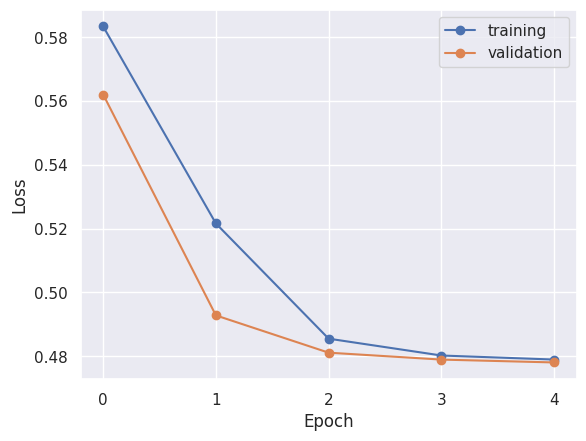

In [126]:
history8 = pd.DataFrame(history8.history)
plot_history(history8)

In [127]:
#Building Embeddings Model
def embeddings_model_9(vocab_size=150, sequence_length=150, embedding_dim=2):
    """Build a tf.keras model using embeddings."""
    # Clear session and remove randomness.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=sequence_length))
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    model.add(tf.keras.layers.Dense(
        units=32,                    
        activation='softmax'         
        ))
    model.add(tf.keras.layers.Dense(
        units=1,                    
        activation='sigmoid'         
        ))
    model.compile(loss='binary_crossentropy', 
                optimizer='adam',
                metrics=['accuracy'])
    return model

In [128]:
model9 = embeddings_model_9(vocab_size=150, sequence_length=150, embedding_dim=2)
model9.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 2)            300       
                                                                 
 global_average_pooling1d (G  (None, 2)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                96        
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 429
Trainable params: 429
Non-trainable params: 0
_________________________________________________________________


In [129]:
tf.random.set_seed(1)
np.random.seed(1)
history9 = model9.fit(
    X_train_emb, 
    Y_train_emb,
    validation_data=(X_validation_array, Y_validation_array), 
    epochs=5)

Epoch 1/5
4567/4567 [==============================] - 8s 2ms/step - loss: 0.5870 - accuracy: 0.7268 - val_loss: 0.5727 - val_accuracy: 0.7275
Epoch 2/5
4567/4567 [==============================] - 8s 2ms/step - loss: 0.5290 - accuracy: 0.7395 - val_loss: 0.4931 - val_accuracy: 0.7641
Epoch 3/5
4567/4567 [==============================] - 7s 2ms/step - loss: 0.4856 - accuracy: 0.7685 - val_loss: 0.4813 - val_accuracy: 0.7727
Epoch 4/5
4567/4567 [==============================] - 7s 2ms/step - loss: 0.4804 - accuracy: 0.7720 - val_loss: 0.4790 - val_accuracy: 0.7742
Epoch 5/5
4567/4567 [==============================] - 7s 2ms/step - loss: 0.4790 - accuracy: 0.7731 - val_loss: 0.4781 - val_accuracy: 0.7742


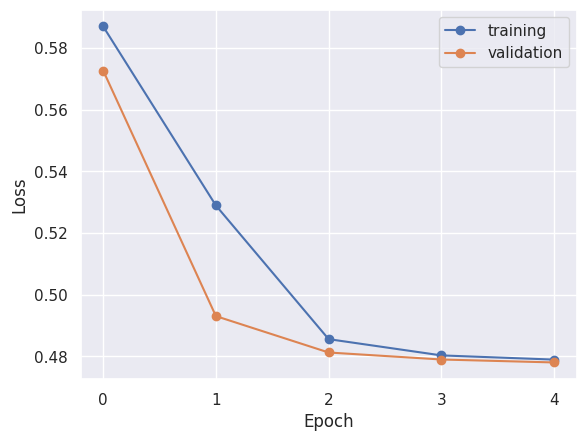

In [130]:
history9 = pd.DataFrame(history9.history)
plot_history(history9)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e3e482f9-f75d-4122-8035-2b3d29cfb3bd' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>